In [49]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /home/phil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# Load stop words
stop_words = set(stopwords.words('english'))

# Load your data
df = pd.read_csv('./nyt-balanced.csv', low_memory=False)



In [41]:
# Preprocess text data
def preprocess_text(text):
    # Tokenize and remove stop words
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]
    return words

df['abstract'] = df['abstract'].fillna('').apply(preprocess_text)
df['lead_paragraph'] = df['lead_paragraph'].fillna('').apply(preprocess_text)

# Combine text features
df['combined_text'] = df['abstract'] + df['lead_paragraph']

# Train Word2Vec model on combined text
w2v_model = Word2Vec(df['combined_text'], vector_size=100, window=5, min_count=1, workers=4)

In [42]:
# Function to average word vectors
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    for word in words:
        if word in vocabulary:
            nwords += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if nwords > 0:
        feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

In [43]:
# Calculate average word vectors for each document
vocab = w2v_model.wv.key_to_index
df['vector'] = df['combined_text'].apply(lambda x: average_word_vectors(x, w2v_model, vocab, 100))

In [44]:
# Split data
X = np.array(df['vector'].tolist())
y = (df['front_page'] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/home/phil/.pyenv/versions/3.10.8/envs/datasci200/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:25:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [59]:
y_pred = xgb_model.predict(X_train)

In [57]:
# Predict and evaluate

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.80425
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     28223
           1       0.68      0.62      0.65     11777

    accuracy                           0.80     40000
   macro avg       0.77      0.75      0.76     40000
weighted avg       0.80      0.80      0.80     40000



In [58]:
def calculate_scores(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

calculate_scores(y_test, y_pred)

(0.6845945187540923, 0.6214655684809374, 0.6515043617589461, 0.80425)

In [60]:
calculate_scores(y_train, y_pred)

(0.7836798241597216, 0.7241875423155044, 0.7527600615790632, 0.859475)

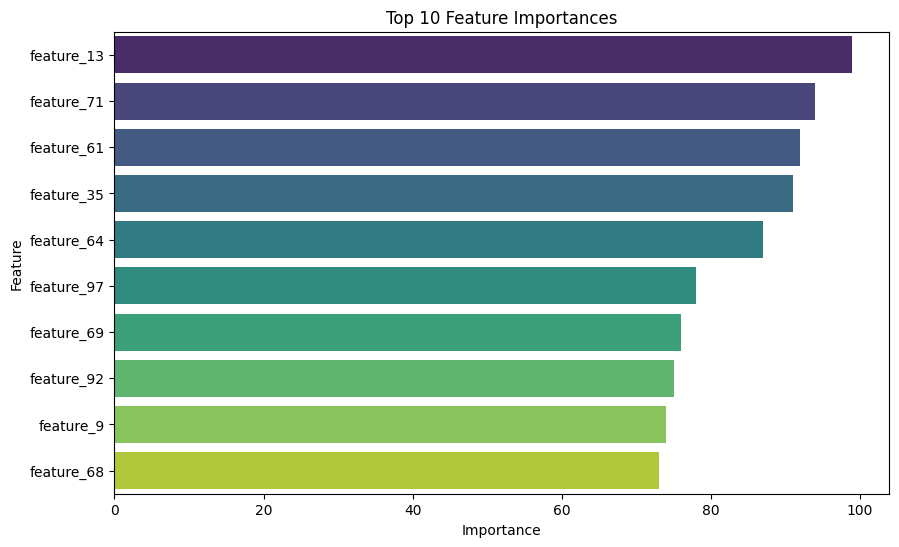

In [10]:
# Extract feature importances
importance = xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': [f'dim_{i}' for i in range(X.shape[1])],
    'Importance': list(importance.values())
})

# Sort by importance and select top 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()